<a href="https://colab.research.google.com/github/vferman2000/Springboard/blob/master/OptimizerSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fashion Image Classification Project
The objective of the project is to build a Convolutional Neural Network model to classify fashion product images using TensorFow and Keras functional API. The model will then predict the class of a given input image.

The dataset can be downloaded from https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset

The platform selected for the project is Google Collab.

This notebook contains model comparisons using different optimization techniques.

In [ ]:
# Install TensorFlow
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# importing additional libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os

# Mounting to Google Drive

In [ ]:
# Path to fashion product images files on Google Drive

DATASET_PATH = "/content/drive/My Drive/Springboard Data Science/CapstoneTwo/fashion-product-images-small/myntradataset/"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


In [ ]:
# Reading df_style pandas dataframe which contains images attributes

df_styles = pd.read_csv(DATASET_PATH + 'styles.csv', error_bad_lines=False)
df_styles['image'] = df_styles.apply(lambda row: str(row['id']) + ".jpg", axis=1)
#df_styles['image'] = df_styles.id.apply(lambda row: "%s.jpg" % row)

df_styles['masterCategory'] = df_styles.masterCategory.apply(lambda row: 'NA' if row is np.nan else row)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [ ]:
# There is only one sample in the Home category.  It will be omitted.
df_styles_labels = df_styles[df_styles.masterCategory != 'Home']

Splitting dataset into train, validation and test subsets where each subset is stratisfied by the categorical values in the masterCategory column of the df_styles dataframe.

A control group is also created and saved as unseen data.

In [ ]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.60, frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_styles.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_validation, df_test, y_validation, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_validation) + len(df_test)

    return df_train, df_validation, df_test

In [ ]:
df_train, df_validation, df_test = \
    split_stratified_into_train_val_test(df_styles_labels, stratify_colname='masterCategory', frac_train=0.60, frac_val=0.15, frac_test=0.25)

# Sampling structure
*   The train subset has 26653 samples.
*   The validation subset has 6663 samples.
*   The test subset has 7774 samples.
*   The control group subset has 3333 samples



In [ ]:
y_test = df_test.masterCategory
df_test_group, df_control_group, y_test_group, y_control_group = train_test_split(df_test, y_test, test_size=.30, stratify=y_test)

In [ ]:
print('The train subset has', len(df_train),'samples')
print('The validation subset has', len(df_validation),'samples')
print('The test group subset has', len(df_test_group),'samples')
print('The control group subset has', len(df_control_group),'samples')

The train subset has 26653 samples
The validation subset has 6663 samples
The test group subset has 7774 samples
The control group subset has 3333 samples


In [ ]:
# Path to images folder
images_data = DATASET_PATH+"images/"

In [ ]:
# number of classes in masterCategory column of df_train
K = len(set(df_train.iloc[:,2]))
print('The number of classes is', K)

The number of classes is 6


# Building the Convolutional Neural Network Model

The input image is 80x60 in size with a RGB channel. We will build a CNN model with a convolution + pooling architecture, followed by a number of fully connected Dense layers. 

The activation function for the convolutional layers will be ReLU ((Rectified Linear Units). 

The output layer will utilize a softmax activiation function for the multiclass classification.

The hyperparameters that will be used are:
MaxPooling2d(2, 2) which extracts certain features from the image and reduces its height and the width. By using 2 pooling layers, the height and width are 1/4 of the original sizes.

BatchNormalization which regularizes and makes the training of convolutional neural networks more efficient.

Dropout to avoid overfitting

In [ ]:
# Build the convolutional Neural Network model using the functional API

# Input node. image shape: 80 x 60 x 3 RGB channels
i= Input(shape=(80, 60, 3))


# 2D convolutional layer with 2 spatial dimensions (height and width)
# Using more filters results in a more powerful model, but we risk overfitting due to increased parameter count.
# 32 initial output feature maps that will progressively increase with network depth. (Starts low to check for overfitting)
# A 3D filter with 3x3x3 dimensions
# A ReLU activation funcion

x = Conv2D(32, (3, 3), activation='relu', padding='valid')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)

# Pooling layer to reduce dimensionality (max pooling takes the maximum value in the pooling window)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Second convolutinal layer with increased number of feature maps
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Third convolutinal layer with increased number of feature maps
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Converting layer to 1 dimensional layer
x = Flatten()(x)
x = Dropout(0.2)(x)

# Fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Fully connected layer with Softmax activation function for multiclass classification probability
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

# Mapping images to MasterCategory classes in df_styles using ImageDataGenerator

In [ ]:
# Using ImageDataGenerator to correlate images from image folder to masterCategory column in df_train, df_validation an df_test 

from keras.preprocessing.image import ImageDataGenerator
HEIGHT = 80
WIDTH = 60
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
                    dataframe=df_train,
                    directory=images_data,
                    x_col="image",
                    y_col="masterCategory",
                    batch_size=batch_size,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=['Footwear', 'Apparel', 'Accessories', 'Personal Care','Free Items','Sporting Goods'],
                    target_size=(HEIGHT,WIDTH))

valid_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_validation,
                    directory=images_data,
                    x_col="image",
                    y_col="masterCategory",
                    batch_size=batch_size,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=['Footwear', 'Apparel', 'Accessories', 'Personal Care', 'Free Items','Sporting Goods'],
                    target_size=(HEIGHT,WIDTH))

test_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_test_group,
                    directory=images_data,
                    x_col="image",
                    batch_size=1,
                    seed=42,
                    shuffle=False,
                    class_mode=None,
                    target_size=(HEIGHT,WIDTH))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 26651 validated image filenames belonging to 6 classes.
Found 6661 validated image filenames belonging to 6 classes.
Found 7773 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Model using stochastic gradient descent (SGD) optimizer

In [ ]:
# Compiling the model
# Learning rate defaults to 0.01

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting the model
model_output = model.fit(train_generator, validation_data=valid_generator, steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=20)

Epoch 1/20
833/832 [==============================] - 7420s 9s/step - loss: 0.2527 - accuracy: 0.9278 - val_loss: 1.4355 - val_accuracy: 0.7054
Epoch 2/20
833/832 [==============================] - 139s 167ms/step - loss: 0.1591 - accuracy: 0.9520 - val_loss: 0.1715 - val_accuracy: 0.9517
Epoch 3/20
833/832 [==============================] - 138s 165ms/step - loss: 0.1294 - accuracy: 0.9613 - val_loss: 0.3121 - val_accuracy: 0.8837
Epoch 4/20
833/832 [==============================] - 138s 166ms/step - loss: 0.1080 - accuracy: 0.9669 - val_loss: 0.1990 - val_accuracy: 0.9300
Epoch 5/20
833/832 [==============================] - 139s 167ms/step - loss: 0.0966 - accuracy: 0.9719 - val_loss: 0.3224 - val_accuracy: 0.8821
Epoch 6/20
833/832 [==============================] - 142s 170ms/step - loss: 0.0885 - accuracy: 0.9738 - val_loss: 0.1298 - val_accuracy: 0.9622
Epoch 7/20
833/832 [==============================] - 142s 171ms/step - loss: 0.0791 - accuracy: 0.9765 - val_loss: 0.1469 - v

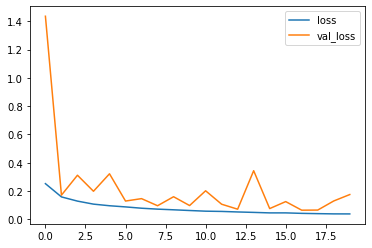

In [ ]:
# Plot loss per iteration
plt.plot(model_output.history['loss'], label='loss')
plt.plot(model_output.history['val_loss'], label='val_loss')
plt.legend()

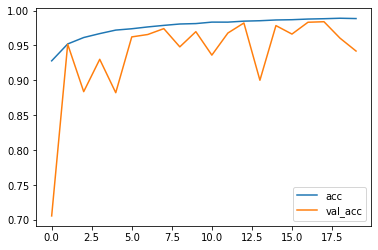

In [ ]:
# Plot accuracy per iteration
plt.plot(model_output.history['accuracy'], label='acc')
plt.plot(model_output.history['val_accuracy'], label='val_acc')
plt.legend()

209/209 [==============================] - 28s 133ms/step
Confusion matrix, without normalization
[[ 405  822  384    0   79    1]
 [ 783 1604  706    0  114    0]
 [ 322  689  319    0   53    0]
 [   3   12    1    0    0    0]
 [ 102  174   70    0   14    0]
 [   0    2    2    0    0    0]]


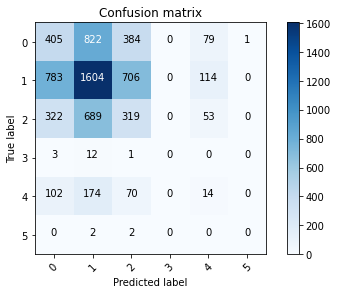

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

valid_generator.reset()
valid_steps_per_epoch = np.math.ceil(valid_generator.samples / valid_generator.batch_size)
p_test=model.predict(valid_generator,verbose=1,steps=valid_steps_per_epoch).argmax(axis=1)

cm = confusion_matrix(valid_generator.classes, p_test)
plot_confusion_matrix(cm, list(range(6)))

In [ ]:
# Build the convolutional Neural Network model using the functional API

# Input node. image shape: 80 x 60 x 3 RGB channels
i= Input(shape=(80, 60, 3))


# 2D convolutional layer with 2 spatial dimensions (height and width)
# Using more filters results in a more powerful model, but we risk overfitting due to increased parameter count.
# 32 initial output feature maps that will progressively increase with network depth. (Starts low to check for overfitting)
# A 3D filter with 3x3x3 dimensions
# A ReLU activation funcion

x = Conv2D(32, (3, 3), activation='relu', padding='valid')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)

# Pooling layer to reduce dimensionality (max pooling takes the maximum value in the pooling window)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Second convolutinal layer with increased number of feature maps
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Third convolutinal layer with increased number of feature maps
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Converting layer to 1 dimensional layer
x = Flatten()(x)
x = Dropout(0.2)(x)

# Fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Fully connected layer with Softmax activation function for multiclass classification probability
x = Dense(K, activation='softmax')(x)

model_2 = Model(i, x)

In [ ]:
# Using ImageDataGenerator to correlate images from image folder to masterCategory column in df_train, df_validation an df_test 

from keras.preprocessing.image import ImageDataGenerator
HEIGHT = 80
WIDTH = 60
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
                    dataframe=df_train,
                    directory=images_data,
                    x_col="image",
                    y_col="masterCategory",
                    batch_size=batch_size,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=['Footwear', 'Apparel', 'Accessories', 'Personal Care','Free Items','Sporting Goods'],
                    target_size=(HEIGHT,WIDTH))

valid_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_validation,
                    directory=images_data,
                    x_col="image",
                    y_col="masterCategory",
                    batch_size=batch_size,
                    seed=42,
                    shuffle=True,
                    class_mode="categorical",
                    classes=['Footwear', 'Apparel', 'Accessories', 'Personal Care', 'Free Items','Sporting Goods'],
                    target_size=(HEIGHT,WIDTH))

test_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_test_group,
                    directory=images_data,
                    x_col="image",
                    batch_size=1,
                    seed=42,
                    shuffle=False,
                    class_mode=None,
                    target_size=(HEIGHT,WIDTH))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 26651 validated image filenames belonging to 6 classes.
Found 6661 validated image filenames belonging to 6 classes.
Found 7773 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


#Model using stochastic gradient descent (SGD) optimizer and a learning rate scheduler
*   Exponential decay learning schedule
*   Initial learning rate of 1e-2



In [ ]:
# Compiling the model
from tensorflow import keras

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.sgd(learning_rate=lr_schedule)

model_2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

A callback object is created to stop training when there is no improvement in the validation loss after 3 consecutive epochs.

In [ ]:
#Setting a callback 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Fitting the model
model_output_2 = model_2.fit(train_generator, validation_data=valid_generator, 
                         steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=100, callbacks=[callback] )



Epoch 1/100
833/832 [==============================] - 144s 173ms/step - loss: 0.3248 - accuracy: 0.9051 - val_loss: 0.1756 - val_accuracy: 0.9460
Epoch 2/100
833/832 [==============================] - 142s 170ms/step - loss: 0.1492 - accuracy: 0.9536 - val_loss: 0.3486 - val_accuracy: 0.8752
Epoch 3/100
833/832 [==============================] - 142s 171ms/step - loss: 0.1143 - accuracy: 0.9656 - val_loss: 0.2884 - val_accuracy: 0.9012
Epoch 4/100
833/832 [==============================] - 143s 172ms/step - loss: 0.0996 - accuracy: 0.9698 - val_loss: 0.1377 - val_accuracy: 0.9580
Epoch 5/100
833/832 [==============================] - 140s 168ms/step - loss: 0.0883 - accuracy: 0.9735 - val_loss: 0.1048 - val_accuracy: 0.9707
Epoch 6/100
833/832 [==============================] - 141s 169ms/step - loss: 0.0784 - accuracy: 0.9760 - val_loss: 0.0992 - val_accuracy: 0.9725
Epoch 7/100
833/832 [==============================] - 143s 172ms/step - loss: 0.0694 - accuracy: 0.9795 - val_loss: 0

In [ ]:
score = model_2.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

209/209 [==============================] - 28s 135ms/step - loss: 0.0532 - accuracy: 0.9881
Test loss: 0.05318356305360794
Test accuracy: 0.9881399273872375


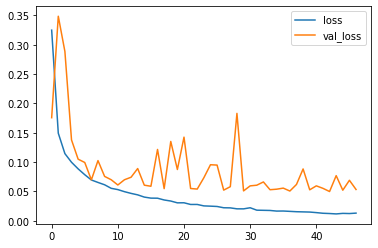

In [ ]:
# Plot loss per iteration
plt.plot(model_output_2.history['loss'], label='loss')
plt.plot(model_output_2.history['val_loss'], label='val_loss')
plt.legend()

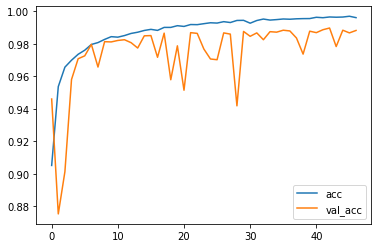

In [ ]:
# Plot accuracy per iteration
plt.plot(model_output_2.history['accuracy'], label='acc')
plt.plot(model_output_2.history['val_accuracy'], label='val_acc')
plt.legend()

209/209 [==============================] - 27s 131ms/step
Confusion matrix, without normalization
[[ 420  815  364    4   87    1]
 [ 790 1567  657    2  190    1]
 [ 364  649  286    3   80    1]
 [   2   10    4    0    0    0]
 [ 102  174   64    1   19    0]
 [   1    1    2    0    0    0]]


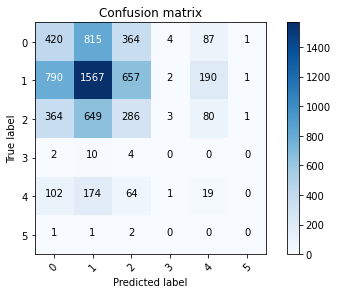

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

valid_generator.reset()
valid_steps_per_epoch = np.math.ceil(valid_generator.samples / valid_generator.batch_size)
p_test=model_2.predict(valid_generator,verbose=1,steps=valid_steps_per_epoch).argmax(axis=1)

cm = confusion_matrix(valid_generator.classes, p_test)
plot_confusion_matrix(cm, list(range(6)))

In [ ]:
# saving the model
model_2.save('/content/drive/My Drive/Springboard Data Science/CapstoneTwo/10model.h5')
model_2.save('/content/drive/My Drive/Springboard Data Science/CapstoneTwo/10model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Springboard Data Science/CapstoneTwo/7model/assets


In [ ]:
test_generator.reset()

In [ ]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
pred=model_2.predict(test_generator,verbose=1,steps=test_steps_per_epoch)

7773/7773 [==============================] - 1910s 246ms/step


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"image":filenames,
                      "predictions":predictions})

In [ ]:
true_and_predicted_labels = pd.merge(df_test[['id','image','masterCategory']], results, on="image")
true_and_predicted_labels.head()
x = true_and_predicted_labels['masterCategory'].unique()
print(x)

['Personal Care' 'Apparel' 'Footwear' 'Accessories' 'Free Items'
 'Sporting Goods']


In [ ]:
true_and_predicted_labels['correct_label'] = np.where(true_and_predicted_labels.masterCategory == true_and_predicted_labels.predictions, 1, 0)
true_and_predicted_labels.head()


,id,image,masterCategory,predictions,correct_label
0,49154,49154.jpg,Personal Care,Personal Care,1
1,27873,27873.jpg,Apparel,Apparel,1
2,46705,46705.jpg,Personal Care,Personal Care,1
3,4485,4485.jpg,Footwear,Footwear,1
4,25372,25372.jpg,Apparel,Apparel,1


#Model using Adams optimizer and a learning rate scheduler
*   Exponential decay learning schedule
*   Initial learning rate of 1e-2

In [ ]:
# Build the convolutional Neural Network model using the functional API

# Input node. image shape: 80 x 60 x 3 RGB channels
i= Input(shape=(80, 60, 3))


# 2D convolutional layer with 2 spatial dimensions (height and width)
# Using more filters results in a more powerful model, but we risk overfitting due to increased parameter count.
# 32 initial output feature maps that will progressively increase with network depth. (Starts low to check for overfitting)
# A 3D filter with 3x3x3 dimensions
# A ReLU activation funcion

x = Conv2D(32, (3, 3), activation='relu', padding='valid')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)

# Pooling layer to reduce dimensionality (max pooling takes the maximum value in the pooling window)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Second convolutinal layer with increased number of feature maps
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

#Third convolutinal layer with increased number of feature maps
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Converting layer to 1 dimensional layer
x = Flatten()(x)
x = Dropout(0.2)(x)

# Fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Fully connected layer with Softmax activation function for multiclass classification probability
x = Dense(K, activation='softmax')(x)

model_3= Model(i, x)


In [ ]:
# Compiling the model
from tensorflow import keras

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model_3.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Setting a callback 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Fitting the model
model_output_3 = model_3.fit(train_generator, validation_data=valid_generator, 
                         steps_per_epoch=int(train_generator.samples)/ batch_size, epochs=100, callbacks=[callback] )

Epoch 1/100
833/832 [==============================] - 145s 174ms/step - loss: 1.1962 - accuracy: 0.8568 - val_loss: 0.3597 - val_accuracy: 0.9008
Epoch 2/100
833/832 [==============================] - 147s 177ms/step - loss: 0.2835 - accuracy: 0.9126 - val_loss: 0.2220 - val_accuracy: 0.9309
Epoch 3/100
833/832 [==============================] - 148s 177ms/step - loss: 0.2220 - accuracy: 0.9318 - val_loss: 0.2776 - val_accuracy: 0.9236
Epoch 4/100
833/832 [==============================] - 150s 180ms/step - loss: 0.1998 - accuracy: 0.9402 - val_loss: 0.9088 - val_accuracy: 0.7874
Epoch 5/100
833/832 [==============================] - 148s 178ms/step - loss: 0.2037 - accuracy: 0.9423 - val_loss: 0.2471 - val_accuracy: 0.9255
Epoch 6/100
833/832 [==============================] - 151s 181ms/step - loss: 0.1928 - accuracy: 0.9475 - val_loss: 0.3180 - val_accuracy: 0.8993
Epoch 7/100
833/832 [==============================] - 149s 179ms/step - loss: 0.1949 - accuracy: 0.9468 - val_loss: 0

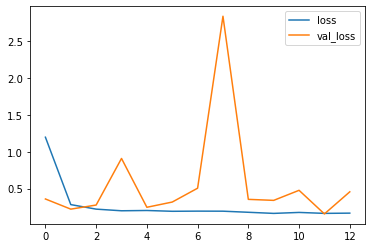

In [ ]:
# Plot loss per iteration
plt.plot(model_output_3.history['loss'], label='loss')
plt.plot(model_output_3.history['val_loss'], label='val_loss')
plt.legend()

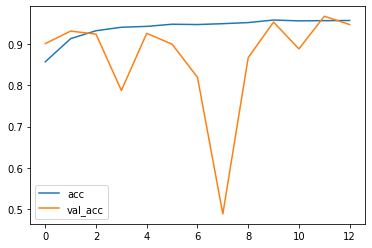

In [ ]:
# Plot accuracy per iteration
plt.plot(model_output_3.history['accuracy'], label='acc')
plt.plot(model_output_3.history['val_accuracy'], label='val_acc')
plt.legend()